In [1]:
import numpy as np
import pandas as pd
import utils_data as ud
import utils_info as info
import utils_regress as ur
import utils_matrixes as um
import constants as cons
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
register_matplotlib_converters()

'''
    General settings
'''

target_name = cons.TIMESERIES_TARGET_NAME
temperature_name = cons.TEMPERATURE_NAME
source_folder = cons.SOURCE_FILES_FOLDER
calendar_folder = cons.CALENDAR_FOLDER
forecast_folder = cons.FORECAST_FILE_FOLDER
model_folder = cons.MODEL_FOLDER
benchmark_folder = cons.BENCHMARK_FOLDER
log_folder = cons.LOGS_FOLDER
horison = cons.FORECAST_HORISON

company = 'Company'
hub = 'HUB1'                

model_info = info.get_model_info(company, hub)

'''

Model settings to be saved

'''
min_lag_une = 192
model_settings = info.get_model_settings_regress(company, hub, min_lag_une)

'''

Training settings

'''

date_start = model_settings['train_date_start']
date_end = model_settings['train_date_end']
tst_split_date = model_settings['train_date_split']
temperature_split_date = date_start

save_benchmark = False
save_model = False

benchmark_modelname = hub + '_lags_' + str(model_settings['min_lag']) + '_regress_train_result.xlsx'
benchmark_filename = ud.get_filename(benchmark_folder, company, hub, benchmark_modelname)
benchmark_sheetname = 'regress'

'''
    Main
'''

data = ud.get_data(model_info['actuals_filename'], date_start, date_end, model_info['actuals_dateformat'])

temperature = ud.get_data(model_info['temperature_actuals_filename'],
                          date_start, date_end, model_info['temperature_actuals_dateformat'])
data = ud.add_temperature(data, temperature, model_settings['temperature_settings'])

data = um.get_regress_input_matrix(data, model_info, model_settings, date_start, date_end)
data = ud.clean_data(data)

train_index = data.index < tst_split_date
test_index = data.index >= tst_split_date
train_index_all = np.full(len(data), True)
temperature_train_index = data.index >= temperature_split_date

prediction = pd.DataFrame(np.zeros(len(data)), index=data.index, columns=['prediction'])
print('Data is uploaded')


Data is uploaded


In [2]:
data.head()

,consumption,temperature,holidays,holidays_bunch,holidays_number_in_bunch,holidays_always,sin_1,trend
timestep,,,,,,,,
2014-06-01 01:00:00,308.693,16.600000,0.0,0.0,0.0,0.0,0.932654,0.457317
2014-06-01 02:00:00,297.213,16.166667,0.0,0.0,0.0,0.0,0.932654,0.457329
2014-06-01 03:00:00,288.631,15.733333,0.0,0.0,0.0,0.0,0.932654,0.457340
2014-06-01 04:00:00,281.286,15.300000,0.0,0.0,0.0,0.0,0.932654,0.457352
2014-06-01 05:00:00,264.076,15.166667,0.0,0.0,0.0,0.0,0.932654,0.457364


Accuracy: MAE =  18.36  MWh,  MAPE =  4.40 %, MaxAPE =  36.17 %, APE > 5 =  34.54 %
Accuracy: MAE =  21.80  MWh,  MAPE =  6.28 %, MaxAPE =  12.17 %, APE > 5 =  75.00 %
Global seasonality is done


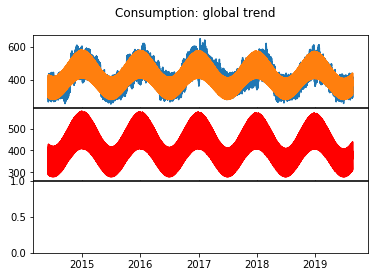

In [3]:
# Global trend


model_settings['global_trend_consumption']['model'] = \
    ur.get_global_trend_model(data, model_settings['global_trend_consumption'])

data['global_trend'] = ur.get_global_trend_values(data, model_settings['global_trend_consumption'])

prediction['global_trend'] = data['global_trend']
prediction['prediction'] = prediction['prediction'].values.ravel() + prediction['global_trend'].values.ravel()
ud.get_accuracy(prediction['prediction'][train_index].values.ravel(), data[target_name][train_index].values.ravel())
ud.get_accuracy(prediction['prediction'][test_index].values.ravel(), data[target_name][test_index].values.ravel())
data['consumption_e1'] = data[target_name].values.ravel() - prediction['prediction'].values.ravel()
print('Global seasonality is done')

f, axarr = plt.subplots(3, sharex=True, sharey=False)
f.suptitle('Consumption: global trend')
axarr[0].plot(data.index, data[target_name])
axarr[0].plot(data.index, prediction['prediction'])
axarr[1].plot(data.index, prediction['global_trend'], '-r')
# axarr[2].plot(data.index, data[new_name])
f.subplots_adjust(hspace=0.01)
for ax in axarr:
    ax.label_outer()
plt.show()


In [4]:
prediction.head()

,prediction,global_trend
timestep,,
2014-06-01 01:00:00,315.230953,315.230953
2014-06-01 02:00:00,304.560123,304.560123
2014-06-01 03:00:00,299.126717,299.126717
2014-06-01 04:00:00,292.133405,292.133405
2014-06-01 05:00:00,288.028406,288.028406


In [5]:
data.head()

,consumption,temperature,holidays,holidays_bunch,holidays_number_in_bunch,holidays_always,sin_1,trend,global_trend,consumption_e1
timestep,,,,,,,,,,
2014-06-01 01:00:00,308.693,16.600000,0.0,0.0,0.0,0.0,0.932654,0.457317,315.230953,-6.537953
2014-06-01 02:00:00,297.213,16.166667,0.0,0.0,0.0,0.0,0.932654,0.457329,304.560123,-7.347123
2014-06-01 03:00:00,288.631,15.733333,0.0,0.0,0.0,0.0,0.932654,0.457340,299.126717,-10.495717
2014-06-01 04:00:00,281.286,15.300000,0.0,0.0,0.0,0.0,0.932654,0.457352,292.133405,-10.847405
2014-06-01 05:00:00,264.076,15.166667,0.0,0.0,0.0,0.0,0.932654,0.457364,288.028406,-23.952406


m =  0
h  =  0
m =  1
h  =  0
m =  2
h  =  0
m =  3
h  =  0
m =  4
h  =  0
Accuracy: MAE =  14.62  MWh,  MAPE =  3.50 %, MaxAPE =  33.06 %, APE > 5 =  23.58 %
Accuracy: MAE =  12.39  MWh,  MAPE =  3.49 %, MaxAPE =  8.46 %, APE > 5 =  14.58 %
Consumption vs temp model is done


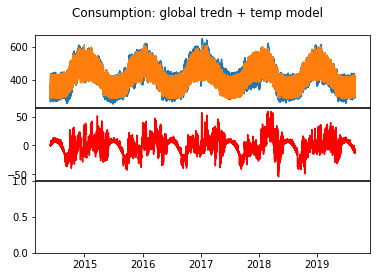

In [6]:


'''

Temperature

'''

model_settings['global_trend_temperature']['model'] = \
    ur.get_global_trend_model(data, model_settings['global_trend_temperature'])

prediction['global_trend_t'] = ur.get_global_trend_values(data, model_settings['global_trend_temperature'])
data['temperature_e1'] = data['temperature'].values.ravel() - prediction['global_trend_t'].values.ravel()

model_settings['temp_model_settings']['model'] = ur.get_temperature_model(data, model_settings['temp_model_settings'])
prediction['temp_model'] = ur.get_temperature_values(data, model_settings['temp_model_settings'])

prediction['prediction'] = prediction['prediction'].values.ravel() + prediction['temp_model'].values.ravel()
ud.get_accuracy(prediction['prediction'][train_index].values.ravel(), data[target_name][train_index].values.ravel())
ud.get_accuracy(prediction['prediction'][test_index].values.ravel(), data[target_name][test_index].values.ravel())
data['consumption_e2'] = data[target_name].values.ravel() - prediction['prediction'].values.ravel()
print('Consumption vs temp model is done')

f, axarr = plt.subplots(3, sharex=True, sharey=False)
f.suptitle('Consumption: global tredn + temp model')
axarr[0].plot(data.index, data[target_name])
axarr[0].plot(data.index, prediction['prediction'])
axarr[1].plot(data.index, prediction['temp_model'], '-r')
# axarr[2].plot(data.index, data['consumption_ee'])
f.subplots_adjust(hspace=0.01)
for ax in axarr:
    ax.label_outer()
plt.show()


In [7]:

'''

Holidays

'''

model_settings['holidays_model'] = ur.get_holidays_model(data, model_info, model_settings)
prediction['holidays_deviation'] = ur.get_holidays_values(data, model_settings)

prediction['prediction'] = prediction['prediction'] + prediction['holidays_deviation']
ud.get_accuracy(prediction['prediction'][train_index].values.ravel(), data[target_name][train_index].values.ravel())
ud.get_accuracy(prediction['prediction'][test_index].values.ravel(), data[target_name][test_index].values.ravel())
data['consumption_e3'] = data[target_name].values.ravel() - prediction['prediction'].values.ravel()
print('Holidays are done')



[ 0.  1.  2.  3.  4.  5.  7.  8. 13. 15.]
[ 1.  2.  3.  4.  5.  7.  8. 13. 15.]
ws (24, 16)
beta_h (361, 40)
d= 1.0
h= 0
h= 1
h= 2
h= 3
h= 4
h= 5
h= 6
h= 7
h= 8
h= 9
h= 10
h= 11
h= 12
h= 13
h= 14
h= 15
h= 16
h= 17
h= 18
h= 19
h= 20
h= 21
h= 22
h= 23
d= 2.0
h= 0
h= 1
h= 2
h= 3
h= 4
h= 5
h= 6
h= 7
h= 8
h= 9
h= 10
h= 11
h= 12
h= 13
h= 14
h= 15
h= 16
h= 17
h= 18
h= 19
h= 20
h= 21
h= 22
h= 23
d= 3.0
h= 0
h= 1
h= 2
h= 3
h= 4
h= 5
h= 6
h= 7
h= 8
h= 9
h= 10
h= 11
h= 12
h= 13
h= 14
h= 15
h= 16
h= 17
h= 18
h= 19
h= 20
h= 21
h= 22
h= 23
d= 4.0
h= 0
h= 1
h= 2
h= 3
h= 4
h= 5
h= 6
h= 7
h= 8
h= 9
h= 10
h= 11
h= 12
h= 13
h= 14
h= 15
h= 16
h= 17
h= 18
h= 19
h= 20
h= 21
h= 22
h= 23
d= 5.0
h= 0
h= 1
h= 2
h= 3
h= 4
h= 5
h= 6
h= 7
h= 8
h= 9
h= 10
h= 11
h= 12
h= 13
h= 14
h= 15
h= 16
h= 17
h= 18
h= 19
h= 20
h= 21
h= 22
h= 23
d= 7.0
h= 0
h= 1
h= 2
h= 3
h= 4
h= 5
h= 6
h= 7
h= 8
h= 9
h= 10
h= 11
h= 12
h= 13
h= 14
h= 15
h= 16
h= 17
h= 18
h= 19
h= 20
h= 21
h= 22
h= 23
d= 8.0
h= 0
h= 1
h= 2
h= 3
h= 4
h= 5
h= 6
h= 

[6 6 6 ... 5 5 5]
['consumption_e3_lag_96', 'consumption_e3_lag_97', 'consumption_e3_lag_98', 'consumption_e3_lag_99', 'consumption_e3_lag_100', 'consumption_e3_lag_101', 'consumption_e3_lag_102', 'consumption_e3_lag_103', 'consumption_e3_lag_104', 'consumption_e3_lag_105', 'consumption_e3_lag_106', 'consumption_e3_lag_107', 'consumption_e3_lag_108', 'consumption_e3_lag_109', 'consumption_e3_lag_110', 'consumption_e3_lag_111', 'consumption_e3_lag_112', 'consumption_e3_lag_113', 'consumption_e3_lag_114', 'consumption_e3_lag_115', 'consumption_e3_lag_116', 'consumption_e3_lag_117', 'consumption_e3_lag_118', 'consumption_e3_lag_119', 'consumption_e3_lag_120', 'consumption_e3_lag_121', 'consumption_e3_lag_122', 'consumption_e3_lag_123', 'consumption_e3_lag_124', 'consumption_e3_lag_125', 'consumption_e3_lag_126', 'consumption_e3_lag_127', 'consumption_e3_lag_128', 'consumption_e3_lag_129', 'consumption_e3_lag_130', 'consumption_e3_lag_131', 'consumption_e3_lag_132', 'consumption_e3_lag_133

(45528, 481)
(45863, 494)
[False False False ...  True  True  True]
0
[0, 1, 2, 3, 4]
1
[5, 6]
Step_1:
Accuracy: MAE =  9.52  MWh,  MAPE =  2.29 %, MaxAPE =  20.43 %, APE > 5 =  9.38 %
Accuracy: MAE =  11.01  MWh,  MAPE =  3.05 %, MaxAPE =  8.20 %, APE > 5 =  31.25 %


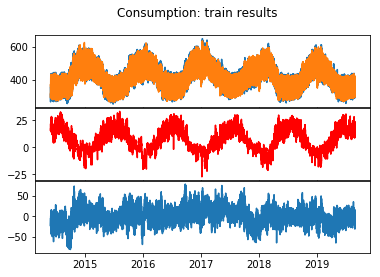

In [8]:
'''

Autoregression

'''

data['prediction'] = prediction['prediction']
data, model_settings, pred_name = um.get_autoregress_results(data, model_settings, 'train')

# print('AES comparison')
# dates_check = pd.date_range(pd.datetime(2018, 1, 1, 0, 0), pd.datetime(2018, 11, 29, 0, 0), freq='H')
# mask_check = prediction.index.isin(dates_check.values)
# ud.get_accuracy(data[pred_name][mask_check].values.ravel(),
#                 data[cons.TIMESERIES_TARGET_NAME][mask_check].values.ravel())

f, axarr = plt.subplots(3, sharex=True, sharey=False)
f.suptitle('Consumption: train results')
axarr[0].plot(data.index, data[target_name])
axarr[0].plot(data.index, data[pred_name])
axarr[1].plot(data.index, data['temperature'], '-r')
axarr[2].plot(data.index, data['consumption_e3'])
f.subplots_adjust(hspace=0.01)
for ax in axarr:
    ax.label_outer()
plt.show()


if save_benchmark:
    cmp_df = data[[cons.TIMESERIES_TARGET_NAME, pred_name]].copy()
    cmp_df.rename(columns={cons.TIMESERIES_TARGET_NAME: 'Fact', pred_name: 'Prediction'}, inplace=True)
    cmp_df.index.name = cons.TIMESTEP_NAME
    mask = cmp_df.index >= pd.datetime(2013, 3, 1)
    cmp_df[mask].to_excel(benchmark_filename, sheet_name=benchmark_sheetname)

if save_model:
    ud.save_model_settings(model_settings, company, hub, 'regress')

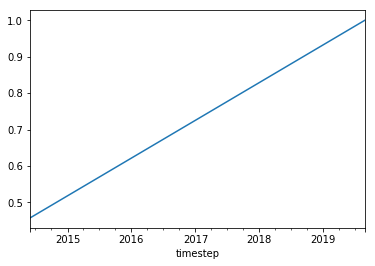

In [11]:
data.trend.plot()